In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import glob
import quadpy
from matplotlib.offsetbox import AnchoredText
import getdist
from getdist import plots, MCSamples
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

gk = quadpy.c1.gauss_kronrod(40)

In [2]:
pantheon_ori_fits=pd.read_csv("pantheon_original_fit.txt",sep="\s+")

In [3]:
p_red=pantheon_ori_fits[(pantheon_ori_fits["HOST_LOGMASS"]>=8.) & (pantheon_ori_fits["HOST_LOGMASS"]<=12.)]

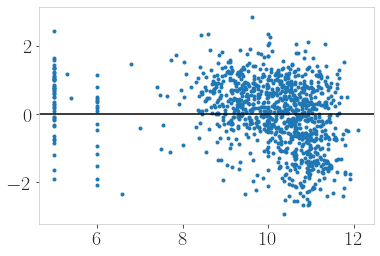

In [4]:
plt.plot(pantheon_ori_fits["HOST_LOGMASS"],pantheon_ori_fits["x1"],'.')
#plt.axvline(x = 10.,ls="--",c="k")
plt.axhline(y = 0.,c="k");

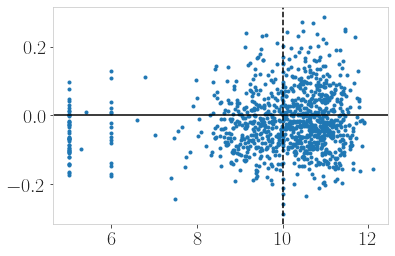

In [5]:
plt.plot(pantheon_ori_fits["HOST_LOGMASS"],pantheon_ori_fits["c"],'.')
plt.axvline(x = 10.,ls="--",c="k")
plt.axhline(y = 0.,c="k");

## Carregando dados EXP

In [6]:
glob.glob("./lc_fit_results*.txt")

['./lc_fit_results_EXP_PCA_LOWZ_Pantheon.txt',
 './lc_fit_results_EXP_PCA_PS1_Pantheon.txt',
 './lc_fit_results_EXP_PCA_SDSS_Pantheon.txt',
 './lc_fit_results_EXP_PCA_HST_Pantheon.txt',
 './lc_fit_results_EXP_PCA_SNLS_Pantheon.txt']

In [7]:
SDSS_fits=pd.read_csv("./lc_fit_results_EXP_PCA_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits=pd.read_csv("./lc_fit_results_EXP_PCA_SNLS_Pantheon.txt",sep="\s+")
PS1_fits=pd.read_csv("./lc_fit_results_EXP_PCA_PS1_Pantheon.txt",sep="\s+")
HST_fits=pd.read_csv("./lc_fit_results_EXP_PCA_HST_Pantheon.txt",sep="\s+")
LOWZ_fits=pd.read_csv("./lc_fit_results_EXP_PCA_LOWZ_Pantheon.txt",sep="\s+")

In [8]:
df_exp_bf_cuts=pd.concat([PS1_fits,LOWZ_fits,SDSS_fits,SNLS_fits,HST_fits])

In [9]:
x1_2sig=np.percentile(df_exp_bf_cuts[abs(df_exp_bf_cuts["X1"])<10.]["X1"],[10,50,90])
x2_2sig=np.percentile(df_exp_bf_cuts[abs(df_exp_bf_cuts["X2/C"])<10.]["X2/C"],[10,50,90])
x1err_2sig=np.percentile(df_exp_bf_cuts[abs(df_exp_bf_cuts["X1ERR"])<10.]["X1ERR"],[1,50,99])
x2err_2sig=np.percentile(df_exp_bf_cuts[abs(df_exp_bf_cuts["X2/CERR"])<10.]["X2/CERR"],[1,50,99])

In [10]:
df_exp=df_exp_bf_cuts[(df_exp_bf_cuts["X1"]>=-3.5) & (df_exp_bf_cuts["X1"]<=3.) &
                      (df_exp_bf_cuts["X2/C"]>=-3.) & (df_exp_bf_cuts["X2/C"]<=3.) &
                      (df_exp_bf_cuts["X1ERR"]>=0.) & (df_exp_bf_cuts["X1ERR"]<=10.) &
                      (df_exp_bf_cuts["X2/CERR"]>=0.) & (df_exp_bf_cuts["X2/CERR"]<=10.) &
                      (df_exp_bf_cuts["CHISQ/NDOF"]<=15.)].reset_index(drop=True)

#### Visualizando quantas SN de cada subamostra perdemos

In [11]:
SDSS_after_cuts=len(df_exp[df_exp["SURVEY"]=="SDSS"])
SNLS_after_cuts=len(df_exp[df_exp["SURVEY"]=="SNLS"])
PS1_after_cuts=len(df_exp[df_exp["SURVEY"]=="PS1MD"])
HST_after_cuts=len(df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(CANDELS)"])+len(df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(HST)"])+len(df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(SNAP)"])
LOWZ_after_cuts=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3S)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3K)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p1)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p2)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CSP)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA1)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA2)"])

In [12]:
hst_comb=pd.concat((df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(CANDELS)"], df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(HST)"],df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(SNAP)"]),axis=0).reset_index(drop=True)

In [13]:
lowz_comb=pd.concat((df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3S)"],df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3K)"],
                     df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p1)"],df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p2)"],
                     df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA1)"],df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA2)"]),axis=0).reset_index(drop=True)

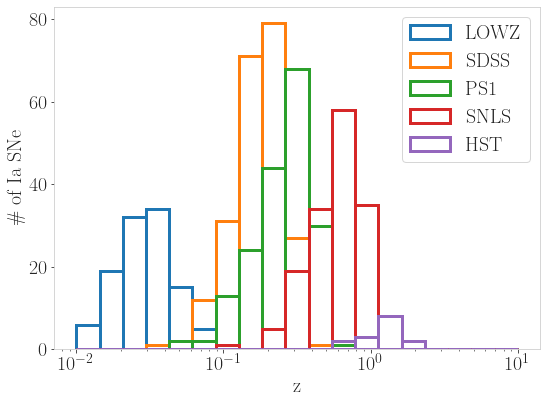

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

bins=np.logspace(-2,1,20)
ax.hist(lowz_comb["Z"],color="C0",bins=bins,label="LOWZ",edgecolor="C0",fill=False,lw=3)
ax.hist(df_exp[df_exp["SURVEY"]=="SDSS"]["Z"],color="C1",bins=bins,label="SDSS",edgecolor="C1",fill=False,lw=3)
ax.hist(df_exp[df_exp["SURVEY"]=="PS1MD"]["Z"],color="C2",bins=bins,label="PS1",edgecolor="C2",fill=False,lw=3)
ax.hist(df_exp[df_exp["SURVEY"]=="SNLS"]["Z"],color="C3",bins=bins,label="SNLS",edgecolor="C3",fill=False,lw=3)
ax.hist(hst_comb["Z"],color="C4",bins=bins,label="HST",edgecolor="C4",fill=False,lw=3)
ax.set_xlabel("z")
ax.set_ylabel("\# of Ia SNe")
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
plt.savefig('./sample_distribution_w_redshift.pdf')  

In [15]:
print(f"SDSS antes dos cortes: {len(SDSS_fits)}, após os cortes: {SDSS_after_cuts}")
print(f"SNLS antes dos cortes: {len(SNLS_fits)}, após os cortes: {SNLS_after_cuts}")
print(f"PS1 antes dos cortes: {len(PS1_fits)}, após os cortes: {PS1_after_cuts}")
print(f"HST antes dos cortes: {len(HST_fits)}, após os cortes: {HST_after_cuts}")
print(f"LOWZ antes dos cortes: {len(LOWZ_fits)}, após os cortes: {LOWZ_after_cuts}")

SDSS antes dos cortes: 313, após os cortes: 224
SNLS antes dos cortes: 236, após os cortes: 152
PS1 antes dos cortes: 271, após os cortes: 184
HST antes dos cortes: 25, após os cortes: 15
LOWZ antes dos cortes: 172, após os cortes: 116


In [16]:
CFA3S_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3S)"])
CFA3S=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3S)"])
CFA3K_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3K)"])
CFA3K=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3K)"])
CFA4p1_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p1)"])
CFA4p1=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p1)"])
CFA4p2_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p2)"])
CFA4p2=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p2)"])
CSP_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CSP)"])
CSP=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CSP)"])
CFA1_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA1)"])
CFA1=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA1)"])
CFA2_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA2)"])
CFA2=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA2)"])

In [17]:
print(f"CFA3S antes dos cortes: {CFA3S_bf}, após os cortes: {CFA3S}")
print(f"CFA3K antes dos cortes: {CFA3K_bf}, após os cortes: {CFA3K}")
print(f"CFA4p1 antes dos cortes: {CFA4p1_bf}, após os cortes: {CFA4p1}")
print(f"CFA4p2 antes dos cortes: {CFA4p2_bf}, após os cortes: {CFA4p2}")
print(f"CSP antes dos cortes: {CSP_bf}, após os cortes: {CSP}")
print(f"CFA1 antes dos cortes: {CFA1_bf}, após os cortes: {CFA1}")
print(f"CFA2 antes dos cortes: {CFA2_bf}, após os cortes: {CFA2}")

CFA3S antes dos cortes: 31, após os cortes: 19
CFA3K antes dos cortes: 60, após os cortes: 38
CFA4p1 antes dos cortes: 33, após os cortes: 28
CFA4p2 antes dos cortes: 10, após os cortes: 7
CSP antes dos cortes: 11, após os cortes: 4
CFA1 antes dos cortes: 9, após os cortes: 8
CFA2 antes dos cortes: 18, após os cortes: 12


### Visualizando distribuições e correlações EXP

In [18]:
total_exp=len(df_exp_bf_cuts)
passcut_exp_x1=len(df_exp_bf_cuts[(df_exp_bf_cuts["X1"]>=-3.5) & (df_exp_bf_cuts["X1"]<=3.)])
passcut_exp_x2=len(df_exp_bf_cuts[abs(df_exp_bf_cuts["X2/C"])<=3.])
passcut_exp_chi2=len(df_exp_bf_cuts[df_exp_bf_cuts["CHISQ/NDOF"]<=15.])
passcut_exp_x1err=len(df_exp_bf_cuts[df_exp_bf_cuts["X1ERR"]<=10.])
passcut_exp_x2err=len(df_exp_bf_cuts[df_exp_bf_cuts["X2/CERR"]<=10.])

De um total 1048 SNe, 1017 foram bem ajustadas.
197 não passaram no corte de |X1| < 3.
216 não passaram no corte de |X2| < 3.
53 não passaram no corte de Chi2 < 15.
11 não passaram no corte de x1err < 10.
14 não passaram no corte de x2err < 10.
No final ficamos com 691 Sne.


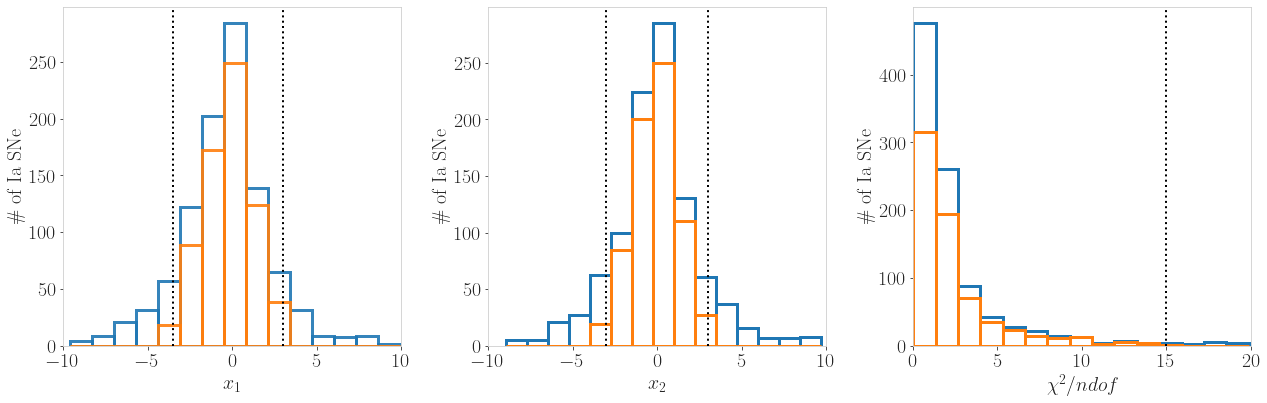

In [19]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(18,6))

bins = 15
bf_cuts_reduced=df_exp_bf_cuts[abs(df_exp_bf_cuts["X1"])<=10.]
bins = np.histogram(np.hstack((bf_cuts_reduced["X1"], df_exp["X1"])), bins=bins)[1]
ax1.hist(df_exp_bf_cuts["X1"],bins=bins,edgecolor="C0",alpha=0.9,fill=False,lw=3)
ax1.hist(df_exp["X1"],bins=bins,edgecolor="C1",alpha=0.9,fill=False,lw=3)
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel("\# of Ia SNe")
ax1.set_xlim(-10,10)
ax1.axvline(3.,c="k",ls=":",lw=2)
ax1.axvline(-3.5,c="k",ls=":",lw=2)

bins = 15
bf_cuts_reduced=df_exp_bf_cuts[abs(df_exp_bf_cuts["X2/C"])<=10.]
bins = np.histogram(np.hstack((bf_cuts_reduced["X2/C"], df_exp["X2/C"])), bins=bins)[1]
ax2.hist(df_exp_bf_cuts["X2/C"],bins=bins,edgecolor="C0",fill=False,lw=3)
ax2.hist(df_exp["X2/C"],bins=bins,edgecolor="C1",fill=False,lw=3)
ax2.set_xlabel(r"$x_2$")
ax2.set_ylabel("\# of Ia SNe")
ax2.set_xlim(-10,10)
ax2.axvline(3,c="k",ls=":",lw=2)
ax2.axvline(-3,c="k",ls=":",lw=2)

bins = 15
bf_cuts_reduced=df_exp_bf_cuts[df_exp_bf_cuts["CHISQ/NDOF"]<=20.]
bins = np.histogram(np.hstack((bf_cuts_reduced["CHISQ/NDOF"], df_exp["CHISQ/NDOF"])), bins=bins)[1]
ax3.hist(df_exp_bf_cuts["CHISQ/NDOF"],bins=bins,edgecolor="C0",fill=False,lw=3)
ax3.hist(df_exp["CHISQ/NDOF"],bins=bins,edgecolor="C1",fill=False,lw=3)
ax3.set_xlabel(r"$\chi^2/ndof$")
ax3.set_ylabel("\# of Ia SNe")
ax3.set_xlim(0,20)
ax3.axvline(15.,c="k",ls=":",lw=2)
fig.tight_layout()
plt.savefig('./distribution_PCA_parameters.pdf')  

print(f"De um total 1048 SNe, {total_exp} foram bem ajustadas.")
print(f"{total_exp-passcut_exp_x1} não passaram no corte de |X1| < 3.")
print(f"{total_exp-passcut_exp_x2} não passaram no corte de |X2| < 3.")
print(f"{total_exp-passcut_exp_chi2} não passaram no corte de Chi2 < 15.")
print(f"{total_exp-passcut_exp_x1err} não passaram no corte de x1err < 10.")
print(f"{total_exp-passcut_exp_x2err} não passaram no corte de x2err < 10.")
print(f"No final ficamos com {len(df_exp)} Sne.")

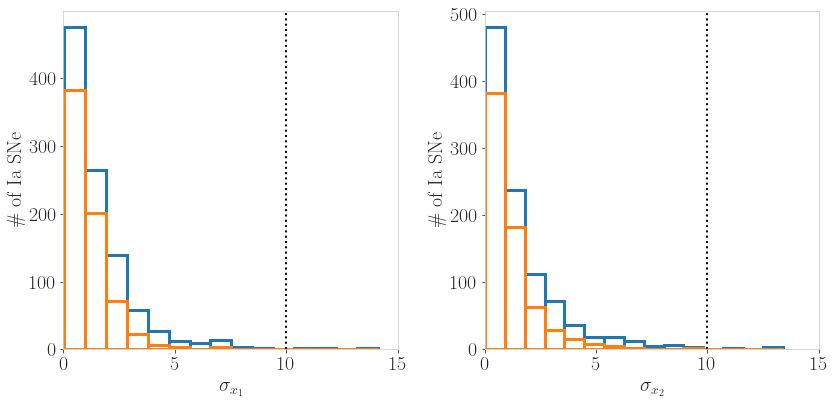

In [20]:
fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=(12,6))

bins = 15
bf_cuts_reduced=df_exp_bf_cuts[df_exp_bf_cuts["X1ERR"]<=15.]
bins = np.histogram(np.hstack((bf_cuts_reduced["X1ERR"], df_exp["X1ERR"])), bins=bins)[1]
ax1.hist(df_exp_bf_cuts["X1ERR"],bins=bins,edgecolor="C0",fill=False,lw=3)
ax1.hist(df_exp["X1ERR"],bins=bins,edgecolor="C1",fill=False,lw=3)
ax1.set_xlabel(r"$\sigma_{x_1}$")
ax1.set_ylabel("\# of Ia SNe")
ax1.set_xlim(0,15)
ax1.axvline(10,c="k",ls=":",lw=2)

bins = 15
bf_cuts_reduced=df_exp_bf_cuts[df_exp_bf_cuts["X2/CERR"]<=15.]
bins = np.histogram(np.hstack((bf_cuts_reduced["X2/CERR"], df_exp["X2/CERR"])), bins=bins)[1]
ax2.hist(df_exp_bf_cuts["X2/CERR"],bins=bins,edgecolor="C0",fill=False,lw=3)
ax2.hist(df_exp["X2/CERR"],bins=bins,edgecolor="C1",fill=False,lw=3)
ax2.set_xlabel(r"$\sigma_{x_2}$")
ax2.set_ylabel("\# of Ia SNe")
ax2.set_xlim(0,15)
ax2.axvline(10,c="k",ls=":",lw=2);

fig.tight_layout()
plt.savefig('./distribution_PCA_parameters_errors.pdf')  

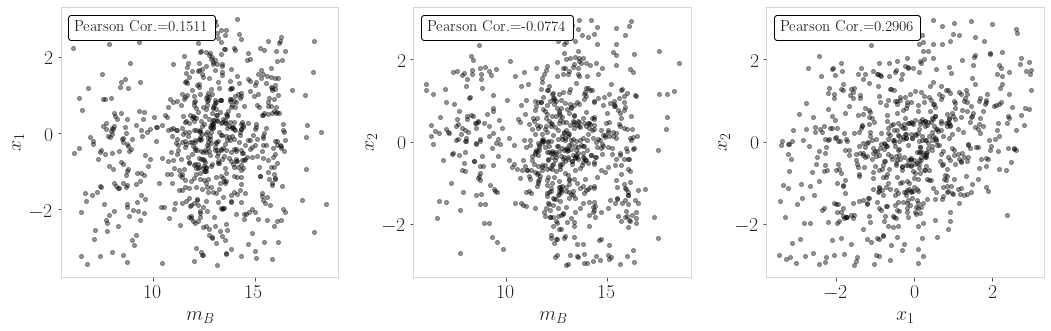

In [38]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(15,5))

ax1.plot(df_exp["mB"],df_exp["X1"],'.',c="k",markersize=8,alpha=0.4)
ax1.set_xlabel(r"$m_B$")
ax1.set_ylabel(r"$x_1$")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_exp["mB"], df_exp["X1"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at1)

ax2.plot(df_exp["mB"],df_exp["X2/C"],'.',c="k",markersize=8,alpha=0.4)
ax2.set_xlabel(r"$m_B$")
ax2.set_ylabel(r"$x_2$")
at2 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_exp["mB"], df_exp["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at2)

ax3.plot(df_exp["X1"],df_exp["X2/C"],'.',c="k",markersize=8,alpha=0.4)
ax3.set_xlabel(r"$x_1$")
ax3.set_ylabel(r"$x_2$")
at3 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_exp["X1"], df_exp["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at3);
fig.tight_layout()
plt.savefig('./distribution_PCA_parameters_correlations.pdf')  

In [22]:
sorted_df=df_exp.sort_values("Z").reset_index(drop=True)

In [35]:
bins_z=[]
bins_x1=[]
bins_x2=[]
i=0
while i< len(sorted_df):
    bins_z.append(np.mean(sorted_df["Z"][i:i+12]))
    bins_x1.append(np.mean(sorted_df["X1"][i:i+12]))
    bins_x2.append(np.mean(sorted_df["X2/C"][i:i+12]))
    i+=12

In [36]:
len(sorted_df)

691

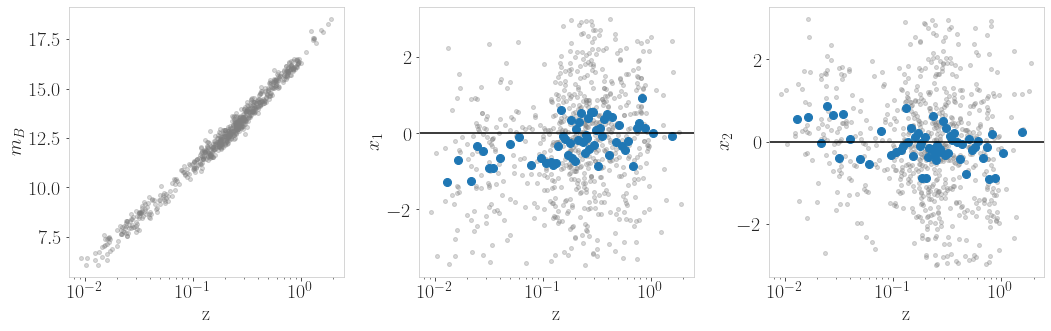

In [37]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(15,5))

ax1.plot(df_exp["Z"],df_exp["mB"],'.',c="C7",markersize=8,alpha=0.3)
ax1.set_ylabel(r"$m_B$")
ax1.set_xlabel("z")
ax1.set_xscale("log")

ax2.plot(df_exp["Z"],df_exp["X1"],".",c="C7",markersize=8,alpha=0.3)
ax2.plot(bins_z,bins_x1,marker="o", markersize=8,ls="none")
ax2.axhline(y=0.,c="k")
ax2.set_ylabel(r"$x_1$")
ax2.set_xlabel("z")
ax2.set_xscale("log")

ax3.plot(df_exp["Z"],df_exp["X2/C"],'.',c="C7",markersize=8,alpha=0.3)
ax3.plot(bins_z,bins_x2,marker="o", markersize=8,ls="none")
ax3.axhline(y=0.,c="k")
ax3.set_ylabel(r"$x_2$")
ax3.set_xlabel("z")
ax3.set_xscale("log")

fig.tight_layout()
plt.savefig('./parameters_dep_w_z.pdf')  

## Carregando dados SALT2

In [26]:
glob.glob("./fits_SALT2/lc_fit_results*.txt")

['./fits_SALT2/lc_fit_results_SALT2_LOWZ_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_HST_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_SNLS_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_SDSS_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_PS1_Pantheon.txt']

In [27]:
SDSS_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_SNLS_Pantheon.txt",sep="\s+")
PS1_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_PS1_Pantheon.txt",sep="\s+")
HST_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_HST_Pantheon.txt",sep="\s+")
LOWZ_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_LOWZ_Pantheon.txt",sep="\s+")

In [28]:
df_salt2_bf_cuts=pd.concat([PS1_fits_SALT2,SNLS_fits_SALT2,SDSS_fits_SALT2,LOWZ_fits_SALT2,HST_fits_SALT2])

In [29]:
df_salt2=df_salt2_bf_cuts[(abs(df_salt2_bf_cuts["X1"])<=3.) & (abs(df_salt2_bf_cuts["X2/C"])<=0.3)].reset_index(drop=True)

### Visualizando distribuições e correlações SALT2

In [30]:
total_salt2=len(df_salt2_bf_cuts)
passcut_salt2_x1=len(df_salt2_bf_cuts[abs(df_salt2_bf_cuts["X1"])<=3])
passcut_salt2_c=len(df_salt2_bf_cuts[abs(df_salt2_bf_cuts["X2/C"])<=0.3])

De um total 1048 SNe, 1044 foram bem ajustadas.
16 não passaram no corte de |X1| < 3.
2 não passaram no corte de |C| < 0.3
No final ficamos com 1027 Sne.


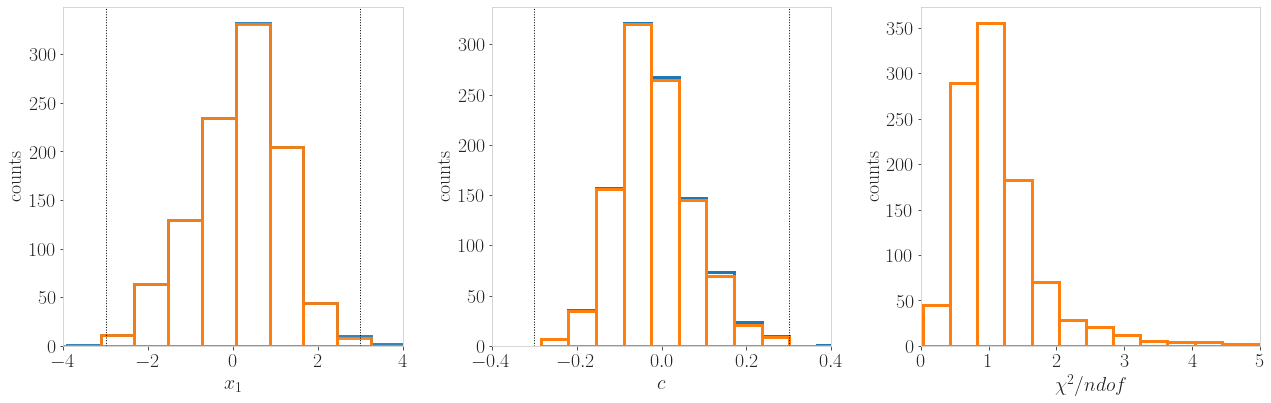

In [31]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(18,6))

bins = 20
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X1"], df_salt2["X1"])), bins=bins)[1]
ax1.hist(df_salt2_bf_cuts["X1"],bins=bins,edgecolor="C0",alpha=0.9,fill=False,lw=3)
ax1.hist(df_salt2["X1"],bins=bins,edgecolor="C1",alpha=0.9,fill=False,lw=3)
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel("counts")
ax1.set_xlim(-4,4)
ax1.axvline(3.,c="k",ls=":",lw=1)
ax1.axvline(-3.,c="k",ls=":",lw=1)

bins = 15
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X2/C"], df_salt2["X2/C"])), bins=bins)[1]
ax2.hist(df_salt2_bf_cuts["X2/C"],bins=bins,edgecolor="C0",fill=False,lw=3)
ax2.hist(df_salt2["X2/C"],bins=bins,edgecolor="C1",fill=False,lw=3)
ax2.set_xlabel(r"$c$")
ax2.set_ylabel("counts")
ax2.set_xlim(-0.4,0.4)
ax2.axvline(0.3,c="k",ls=":",lw=1)
ax2.axvline(-0.3,c="k",ls=":",lw=1)

df_salt2_reduced=df_salt2[df_salt2["CHISQ/NDOF"]<=10.]
ax3.hist(df_salt2_reduced["CHISQ/NDOF"],bins=18,edgecolor="C1",fill=False,lw=3)
ax3.set_xlabel(r"$\chi^2/ndof$")
ax3.set_ylabel("counts")
ax3.set_xlim(0,5)
fig.tight_layout()

print(f"De um total 1048 SNe, {total_salt2} foram bem ajustadas.")
print(f"{total_salt2-passcut_salt2_x1} não passaram no corte de |X1| < 3.")
print(f"{total_salt2-passcut_salt2_c} não passaram no corte de |C| < 0.3")
print(f"No final ficamos com {len(df_salt2)} Sne.")

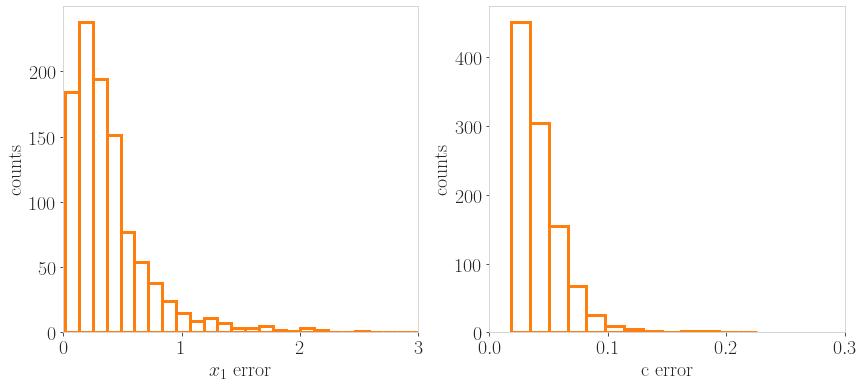

In [32]:
fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=(14,6))

ax1.hist(df_salt2["X1ERR"],bins=60,edgecolor="C1",fill=False,lw=3)
ax1.set_xlabel(r"$x_1$ error")
ax1.set_ylabel("counts")
ax1.set_xlim(0,3)

ax2.hist(df_salt2["X2/CERR"],bins=13,edgecolor="C1",fill=False,lw=3)
ax2.set_xlabel(r"c error")
ax2.set_ylabel("counts")
ax2.set_xlim(0.,0.3);

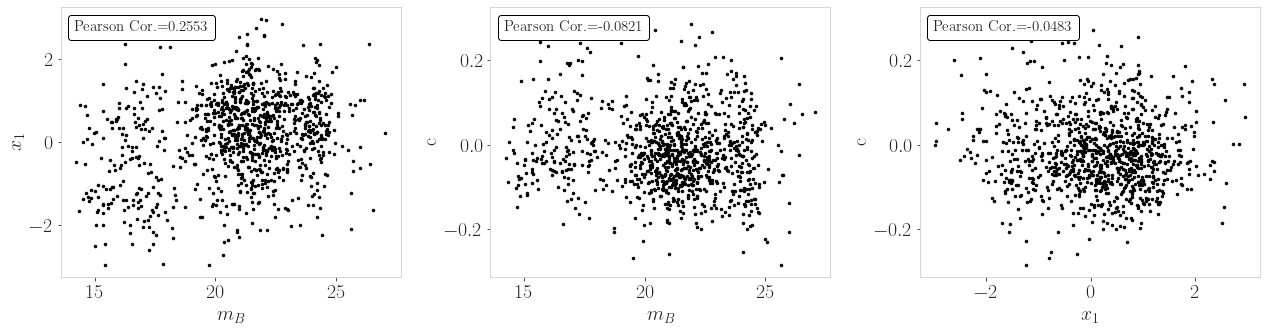

In [33]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(18,5))

ax1.plot(df_salt2["mB"],df_salt2["X1"],'.',c="k",markersize=5)
ax1.set_xlabel(r"$m_B$")
ax1.set_ylabel(r"$x_1$")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X1"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at1)

ax2.plot(df_salt2["mB"],df_salt2["X2/C"],'.',c="k",markersize=5)
ax2.set_xlabel(r"$m_B$")
ax2.set_ylabel(r"c")
at2 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at2)

ax3.plot(df_salt2["X1"],df_salt2["X2/C"],'.',c="k",markersize=5)
ax3.set_xlabel(r"$x_1$")
ax3.set_ylabel(r"c")
at3 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["X1"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at3); 
fig.tight_layout()

## Comparações

In [34]:
surv=[]
mb_salt2=[]
mberr_salt2=[]
mb_exp=[]
mberr_exp=[]
x1_salt2=[]
x1err_salt2=[]
x1_exp=[]
x1err_exp=[]
c_salt2=[]
cerr_salt2=[]
x2_exp=[]
x2err_exp=[]
z=[]
for sn in df_salt2["SNNAME"].values:
    if sn in df_exp["SNNAME"].values:
        surv.append(df_exp[df_exp["SNNAME"]==sn]["SURVEY"].values[0])
        mb_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["mB"].values[0])
        mberr_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["mBERR"].values[0])
        mb_exp.append(df_exp[df_exp["SNNAME"]==sn]["mB"].values[0])
        mberr_exp.append(df_exp[df_exp["SNNAME"]==sn]["mBERR"].values[0])
        x1_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["X1"].values[0])
        x1err_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["X1ERR"].values[0])
        x1_exp.append(df_exp[df_exp["SNNAME"]==sn]["X1"].values[0])
        x1err_exp.append(df_exp[df_exp["SNNAME"]==sn]["X1ERR"].values[0])
        c_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["X2/C"].values[0])
        cerr_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["X2/CERR"].values[0])
        x2_exp.append(df_exp[df_exp["SNNAME"]==sn]["X2/C"].values[0])
        x2err_exp.append(df_exp[df_exp["SNNAME"]==sn]["X2/CERR"].values[0])
        z.append(df_exp[df_exp["SNNAME"]==sn]["Z"].values[0])

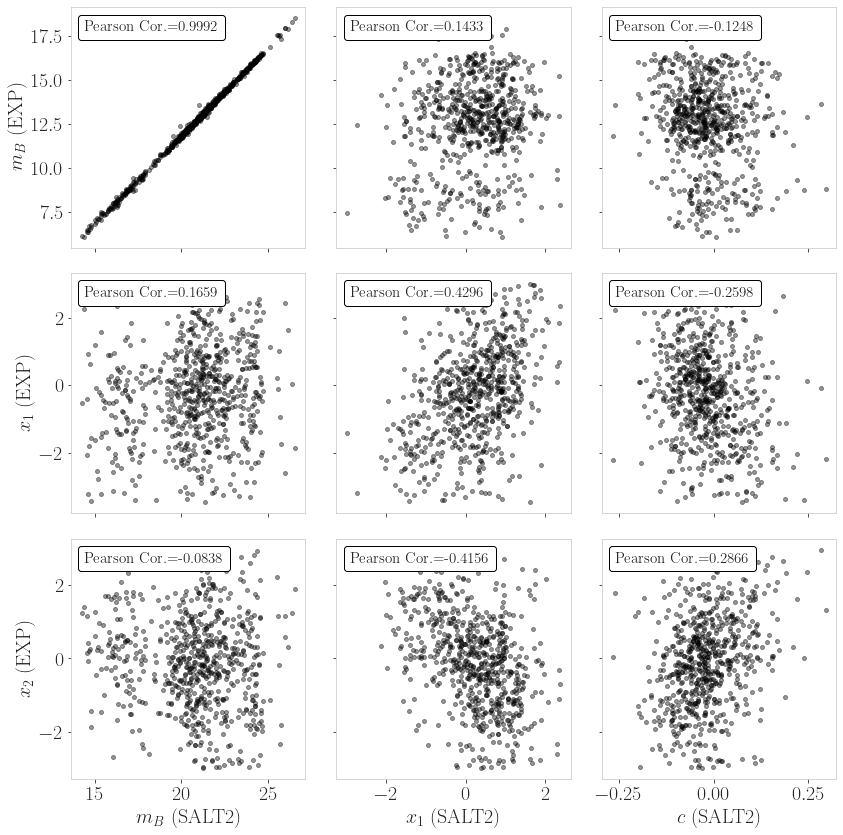

In [35]:
fig, axs=plt.subplots(3,3,figsize=(12,12),sharex='col',sharey='row')

axs[0,0].plot(mb_salt2,mb_exp,'.',c="black",markersize=8,alpha=0.4)
axs[0,0].set_ylabel(r"$m_B$ (EXP)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(mb_salt2, mb_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0,0].add_artist(at1)

axs[0,1].plot(x1_salt2,mb_exp,'.',c="black",markersize=8,alpha=0.4)
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(x1_salt2, mb_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0,1].add_artist(at1)

axs[0,2].plot(c_salt2,mb_exp,'.',c="black",markersize=8,alpha=0.4)
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(c_salt2, mb_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0,2].add_artist(at1)

axs[1,0].plot(mb_salt2,x1_exp,'.',c="black",markersize=8,alpha=0.4)
axs[1,0].set_ylabel(r"$x_1$ (EXP)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(mb_salt2, x1_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1,0].add_artist(at1)

axs[1,1].plot(x1_salt2,x1_exp,'.',c="black",markersize=8,alpha=0.4)
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(x1_salt2, x1_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1,1].add_artist(at1)

axs[1,2].plot(c_salt2,x1_exp,'.',c="black",markersize=8,alpha=0.4)
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(c_salt2, x1_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1,2].add_artist(at1)

axs[2,0].plot(mb_salt2,x2_exp,'.',c="black",markersize=8,alpha=0.4)
axs[2,0].set_ylabel(r"$x_2$ (EXP)")
axs[2,0].set_xlabel(r"$m_B$ (SALT2)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(mb_salt2, x2_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[2,0].add_artist(at1)

axs[2,1].plot(x1_salt2,x2_exp,'.',c="black",markersize=8,alpha=0.4)
axs[2,1].set_xlabel(r"$x_1$ (SALT2)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(x1_salt2, x2_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[2,1].add_artist(at1)

axs[2,2].plot(c_salt2,x2_exp,'.',c="black",markersize=8,alpha=0.4)
axs[2,2].set_xlabel(r"$c$ (SALT2)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(c_salt2, x2_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[2,2].add_artist(at1);
fig.tight_layout()
plt.savefig('./correlation_SALT2_EXP_parameters.pdf')  

## MCMC

#### MCMC EXP

In [36]:
class cosmo:
    def __init__(self, data):
        self.data = data
        
    def dL(self,Ok, integral):
        if(Ok[0]>0.):
            return 1./np.sqrt(Ok[0])*np.sinh(np.sqrt(Ok[0])*np.array(integral))
        elif(Ok[0]==0.):
            return integral
        elif(Ok[0]<0.):
            return 1./np.sqrt(-Ok[0])*np.sin(np.sqrt(-Ok[0])*np.array(integral))
    
    def log_likelihood_exp(self,theta):
        Om, Ol, M, deltaM, alpha, beta, sigma=theta

        Ok=1.-Om-Ol
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*self.dL(np.array([Ok]*len(integral)),integral))+M
        mu=self.data["mB"]-2.5*np.log10(1-self.data["x1"]*alpha+self.data["x2"]*beta)-deltaM*self.data["is_log_mass_g_10"]
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        fator=-2.5/(np.log(10.)*(1-self.data["x1"]*alpha+self.data["x2"]*beta))
        
        cov=-2.*fator*alpha*self.data["cov_mB_x1"]+2.*fator*beta*self.data["cov_mB_x2"]-2.*fator**2*alpha*beta*self.data["cov_x1_x2"]
        sigma2=sigma**2+sigmaz**2.+self.data["mBerr"]**2+fator**2*alpha**2.*self.data["x1err"]**2+fator**2*beta**2.*self.data["x2err"]**2.+cov
        
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def log_likelihood_salt2(self,theta):
        Om, Ol, M, deltaM, alpha, beta, sigma=theta

        Ok=1.-Om-Ol
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*self.dL(np.array([Ok]*len(integral)),integral))+M
        mu=self.data["mB"]+self.data["x1"]*alpha-self.data["x2"]*beta-deltaM*self.data["is_log_mass_g_10"]
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        cov=2.*alpha*self.data["cov_mB_x1"]-2.*beta*self.data["cov_mB_x2"]-2.*alpha*beta*self.data["cov_x1_x2"]
        sigma2=sigma**2+sigmaz**2.+self.data["mBerr"]**2+alpha**2.*self.data["x1err"]**2+beta**2.*self.data["x2err"]**2.+cov
               
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def log_prior_exp(self, theta):
        Om, Ol, M, deltaM, alpha, beta, sigma=theta     
        if not (0.05 < Om < 1. and -0.5 < Ol < 1.5 and 15. < M < 17. and -0.5 < deltaM < 0.5 and -5. < alpha <5. and -5.< beta < 5. and 0.<sigma <0.3):
            return -np.inf
        return 0. 
    
    def log_prior_salt2(self, theta):
        Om, Ol, M, deltaM, alpha, beta, sigma=theta     
        if not (0.05 < Om < 1. and -0.5 < Ol < 1.5 and 22. < M < 27. and -0.5 < deltaM < 0.5 and 0. < alpha < 0.5 and 0.< beta < 5. and 0.<sigma <0.3):
            return -np.inf
        return 0.   
    
    def log_probability_exp(self,theta):
        lp = self.log_prior_exp(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood_exp(theta)
    
    def log_probability_salt2(self,theta):
        lp = self.log_prior_salt2(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood_salt2(theta)

In [37]:
exp_data=df_exp[df_exp["SNNAME"].isin(df_salt2["SNNAME"])].reset_index(drop=True)

In [38]:
exp_data["SNNAME"]=exp_data["SNNAME"].astype("str")

In [39]:
hostmass={}

In [40]:
i=0
j=0
for sn in pantheon_ori_fits["CID"]:
    if sn in exp_data["SNNAME"].values:
        i+=1
        hostmass[sn]=pantheon_ori_fits[pantheon_ori_fits["CID"]==sn]["HOST_LOGMASS"].values[0]
        continue
    else:
        try:
            sn_int=int(sn)
            if str(sn_int) in exp_data["SNNAME"].values:
                i+=1
                hostmass[str(sn_int)]=pantheon_ori_fits[pantheon_ori_fits["CID"]==sn]["HOST_LOGMASS"].values[0]
                continue
            else:
                j+=1
                continue
        except:
            j+=1
            continue

print(f"{j} não estão na lista")
print(f"{i} estão na lista")

364 não estão na lista
684 estão na lista


In [41]:
reduced_exp_data=exp_data[exp_data["SNNAME"].isin(hostmass.keys())].reset_index(drop=True)

In [43]:
col_hostmass=[]
is_log_mass_g_10=[]
for sn in reduced_exp_data["SNNAME"]:
    col_hostmass.append(hostmass[sn])
    if hostmass[sn]<10.:
        is_log_mass_g_10.append(0.)
    else:
        is_log_mass_g_10.append(1.)

In [44]:
col_hostmass=pd.DataFrame(col_hostmass)
col_hostmass.columns=["LOG_HOST_GAL_MASS"]
is_log_mass_g_10=pd.DataFrame(is_log_mass_g_10)
is_log_mass_g_10.columns=["is_log_mass_g_10"]

In [45]:
final_exp_data=pd.concat((reduced_exp_data,col_hostmass,is_log_mass_g_10),axis=1)

In [46]:
data_exp=final_exp_data[["SNNAME","LOG_HOST_GAL_MASS","Z","ZERR","mB","mBERR","X1","X1ERR","X2/C","X2/CERR","COV_mB_X1","COV_mB_X2/C","COV_X1_X2/C","is_log_mass_g_10"]]

In [47]:
data_exp.columns=["sn","log_hm","z","zerr","mB","mBerr","x1","x1err","x2","x2err","cov_mB_x1","cov_mB_x2","cov_x1_x2","is_log_mass_g_10"]

In [48]:
data_exp.to_csv("exp_PCA_fits_table.txt",index=False)

In [49]:
len(data_exp)

684

In [50]:
cosmo_exp=cosmo(data_exp)

In [51]:
cosmo_exp.log_probability_exp([0.3,0.7,16.,0.,0.1,0.1,0.13])

-458.6274619473168

In [51]:
pos = np.array([0.3,0.7,16.,0.,0.1,0.1,0.13])+0.01 *np.random.randn(400, 7)
nwalkers, ndim = pos.shape

In [52]:
with Pool() as pool:
    sampler_exp = emcee.EnsembleSampler(nwalkers, ndim, cosmo_exp.log_probability_exp, pool=pool)
    sampler_exp.run_mcmc(pos, 8000, progress=True)

  0%|                                         | 11/8000 [00:01<17:05,  7.79it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|                                         | 12/8000 [00:01<17:06,  7.78it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|                                         | 13/8000 [00:01<17:01,  7.82it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|                                         | 20/8000 [00:02<17:07,  7.76it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: Runt

In [53]:
np.mean(sampler_exp.get_autocorr_time())

68.24025964306476

In [54]:
np.mean(sampler_exp.acceptance_fraction)

0.48580875

In [55]:
#plt.plot(emcee.autocorr.function_1d(samples_exp[:, 0, 0]))
#plt.axhline(y = 0., color = 'r', linestyle = '-'); 

#### MCMC SALT2

In [56]:
salt2_data=df_salt2[df_salt2["SNNAME"].isin(df_exp["SNNAME"])].reset_index(drop=True)

In [57]:
salt2_data["SNNAME"]=salt2_data["SNNAME"].astype("str")

In [58]:
reduced_salt2_data=salt2_data[salt2_data["SNNAME"].isin(hostmass.keys())].reset_index(drop=True)

In [59]:
col_hostmass=[]
is_log_mass_g_10=[]
for sn in reduced_salt2_data["SNNAME"]:
    col_hostmass.append(hostmass[sn])
    if hostmass[sn]<10.:
        is_log_mass_g_10.append(0.)
    else:
        is_log_mass_g_10.append(1.)

In [60]:
col_hostmass=pd.DataFrame(col_hostmass)
col_hostmass.columns=["LOG_HOST_GAL_MASS"]
is_log_mass_g_10=pd.DataFrame(is_log_mass_g_10)
is_log_mass_g_10.columns=["is_log_mass_g_10"]

In [61]:
final_salt2_data=pd.concat((reduced_salt2_data,col_hostmass,is_log_mass_g_10),axis=1)

In [62]:
data_salt2=final_salt2_data[["SNNAME","LOG_HOST_GAL_MASS","Z","ZERR","mB","mBERR","X1","X1ERR","X2/C","X2/CERR","COV_mB_X1","COV_mB_X2/C","COV_X1_X2/C","is_log_mass_g_10"]]

In [63]:
data_salt2.columns=["sn","log_hm","z","zerr","mB","mBerr","x1","x1err","x2","x2err","cov_mB_x1","cov_mB_x2","cov_x1_x2","is_log_mass_g_10"]

In [64]:
data_salt2.to_csv("SALT2_PCAsubsample_fits_table.txt",index=False)

In [65]:
cosmo_salt2=cosmo(data_salt2)

In [66]:
cosmo_salt2.log_probability_salt2([0.3,0.5,24.,0.,0.1,3.,0.1])

121.2312195461684

In [67]:
pos = np.array([0.3,0.7,24.,0.,0.1,3.,0.1])+0.01 *np.random.randn(400, 7)
nwalkers, ndim = pos.shape

In [68]:
with Pool() as pool:
    sampler_salt2 = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2, pool=pool)
    sampler_salt2.run_mcmc(pos, 8000, progress=True)

100%|███████████████████████████████████████| 8000/8000 [15:57<00:00,  8.36it/s]


In [69]:
np.mean(sampler_salt2.get_autocorr_time())

71.37638450925077

In [70]:
np.mean(sampler_salt2.acceptance_fraction)

0.4863634375

#### Chains EXP

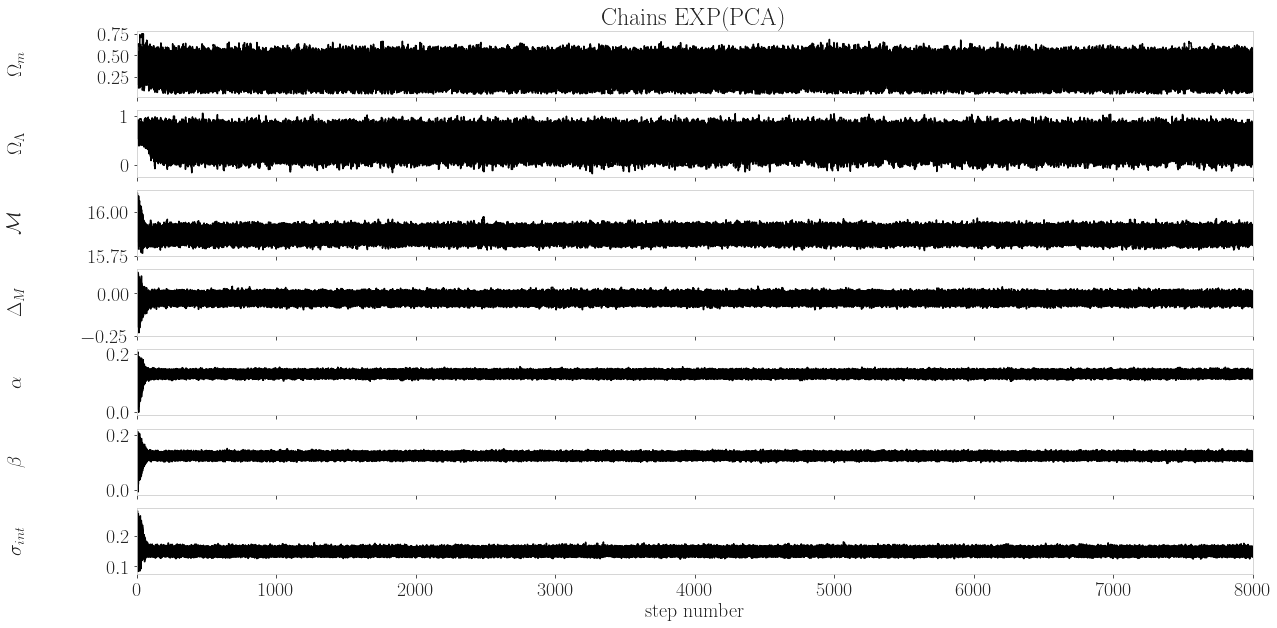

In [71]:
fig, axes = plt.subplots(ndim, figsize=(20, 10), sharex=True)
samples_exp = sampler_exp.get_chain()
labels = [r"$\Omega_m$",r"$\Omega_\Lambda$",r"$\mathcal{M}$", r"$\Delta_M$",r"$\alpha$",r"$\beta$",r"$\sigma_{int}$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_exp[:, :, i], "k")
    ax.set_xlim(0, len(samples_exp))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid(False)
    if i==0:
        ax.set_title("Chains EXP(PCA)")

    
axes[-1].set_xlabel("step number");

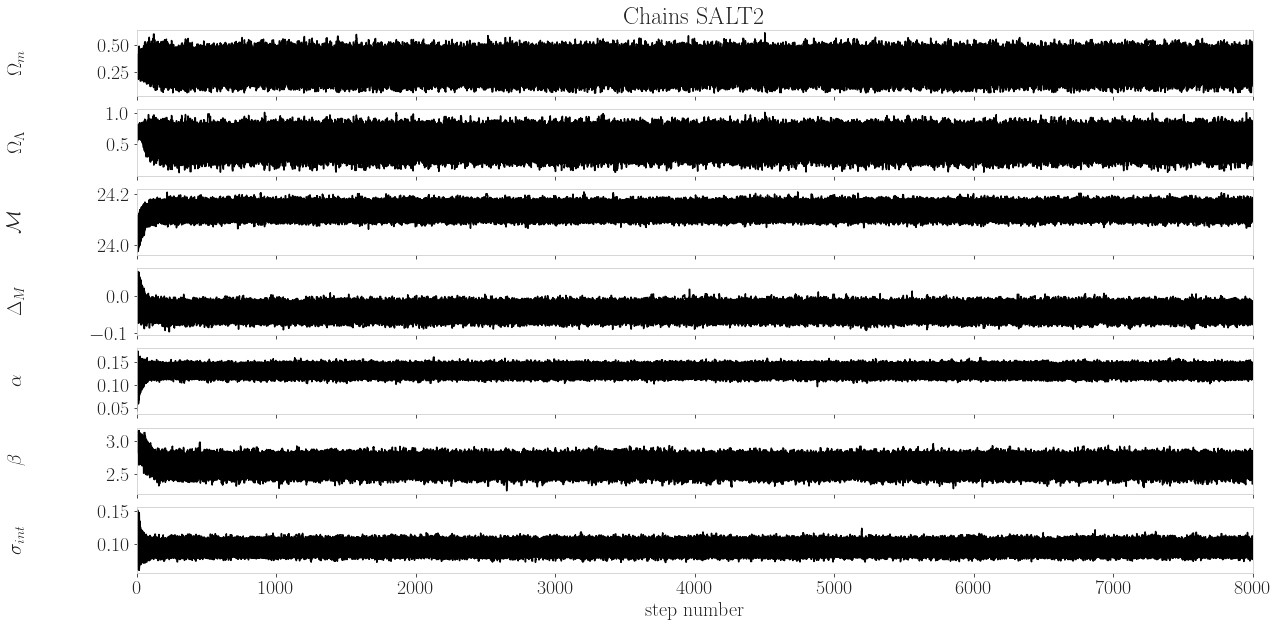

In [72]:
fig, axes = plt.subplots(ndim, figsize=(20, 10), sharex=True)
samples_salt2 = sampler_salt2.get_chain()
labels = [r"$\Omega_m$",r"$\Omega_\Lambda$",r"$\mathcal{M}$", r"$\Delta_M$",r"$\alpha$",r"$\beta$",r"$\sigma_{int}$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2[:, :, i], "k")
    ax.set_xlim(0, len(samples_salt2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid(False)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [73]:
flat_samples_exp = sampler_exp.get_chain(discard=500, thin=10, flat=True)

In [74]:
flat_samples_salt2 = sampler_salt2.get_chain(discard=500, thin=10, flat=True)

In [75]:
np.savetxt("chain_EXP_PCA.txt",flat_samples_exp)

In [76]:
np.savetxt("chain_SALT2_PCAsubsample.txt",flat_samples_salt2)

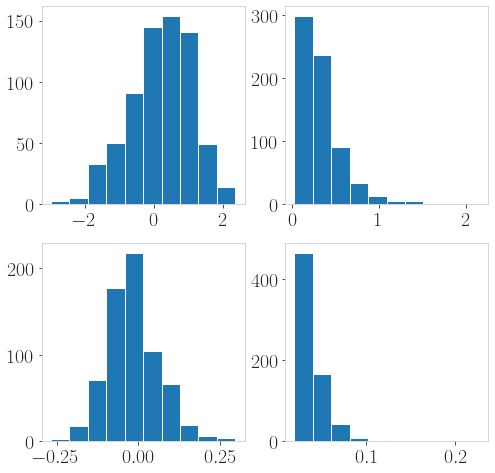

In [77]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

axs[0,0].hist(data_salt2["x1"])
axs[0,1].hist(data_salt2["x1err"])
axs[1,0].hist(data_salt2["x2"])
axs[1,1].hist(data_salt2["x2err"]);